In [ ]:
!pip install pandas scikit-learn matplotlib seaborn flask openpyxl joblib

# load dataset

In [ ]:

from google.colab import files
import pandas as pd

df = pd.read_excel('/content/sample_data/tourist_places_bd_real_desc.xlsx')
print(df.shape)
df.head()


(430, 9)


,place_name,category,budget_level,season,trip_type,duration_days,popularity,location,description
0,Saint Martin's Island,island,high,winter,family,6,7.0,"Bay of Bengal, Teknaf",Saint Martin's Island is Bangladesh's only cor...
1,Bashundhara City,cultural,high,summer,family,5,7.1,"Panthapath, Dhaka",Bashundhara City is one of the largest shoppin...
2,Baitul Mukarram Mosque,religious,high,winter,solo,6,8.4,Dhaka,"Baitul Mukarram Mosque, located in the heart o..."
3,Bhawal National Park,forest,high,winter,family,1,9.0,Gazipur,Bhawal National Park is a serene forest reserv...
4,Paharpur (Somapura Mahavihara),historical,high,summer,family,6,9.1,Naogaon,"Paharpur, home to the ancient Somapura Mahavih..."


# Data preprocessing

In [ ]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)

# Encode categorical columns
categorical_cols = ['category', 'budget_level', 'season', 'trip_type']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scale duration
scaler = StandardScaler()
df['duration_days_scaled'] = scaler.fit_transform(df[['duration_days']])

# Data Distribution Visualization

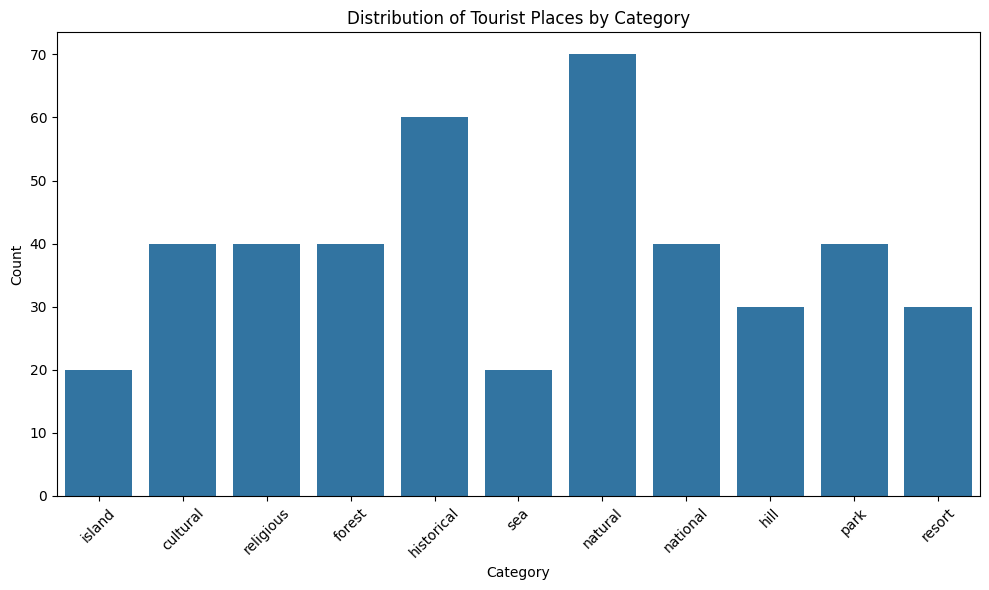

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reverse map from LabelEncoder
category_labels = label_encoders['category'].inverse_transform(df['category'])

# Plot with mapped labels
plt.figure(figsize=(10, 6))
sns.countplot(x=category_labels)
plt.title('Distribution of Tourist Places by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clustering to Group Similar Tourist Places

In [ ]:

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = df[['category', 'budget_level', 'season', 'trip_type', 'duration_days_scaled']]
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(features_pca)

silhouette_avg = silhouette_score(features_pca, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4053889513678745


# PCA Cluster Visualization

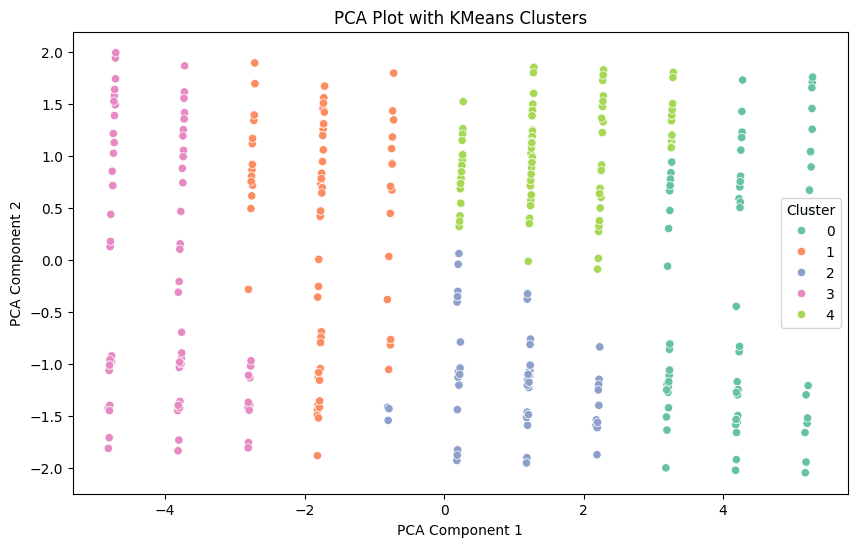

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df['cluster'], palette='Set2')
plt.title('PCA Plot with KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Test split

In [ ]:

X = df[['category', 'budget_level', 'season', 'trip_type', 'duration_days_scaled']]
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training and Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': acc, 'F1 Score': f1}

# Show test results
results_df = pd.DataFrame(results).T
print("Test Set Results:")
display(results_df)


✅ Test Set Results:


,Accuracy,F1 Score
Logistic Regression,0.976744,0.976496
Decision Tree,1.000000,1.000000
Random Forest,0.988372,0.988323
SVM,0.930233,0.931470
KNN,0.941860,0.942764
Naive Bayes,0.790698,0.795704


# Model Performance Visualization

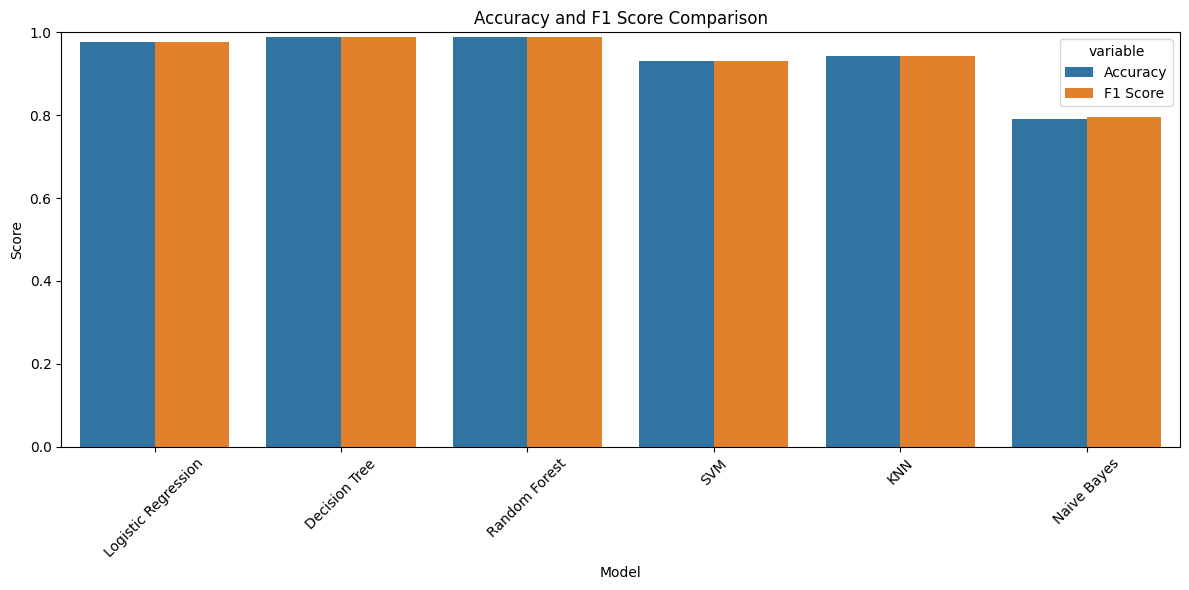

In [ ]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title('Accuracy and F1 Score Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Cross-Validation Results

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_results = {}

for name, model in models.items():
    cv_f1 = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    cv_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    cv_results[name] = {
        'Mean F1 Score': np.mean(cv_f1),
        'Std F1 Score': np.std(cv_f1),
        'Mean Accuracy': np.mean(cv_acc),
        'Std Accuracy': np.std(cv_acc)
    }

cv_df = pd.DataFrame(cv_results).T.sort_values(by="Mean F1 Score", ascending=False)
print("5-Fold Cross-Validation Results:")
display(cv_df)

✅ 5-Fold Cross-Validation Results:


,Mean F1 Score,Std F1 Score,Mean Accuracy,Std Accuracy
Logistic Regression,0.990638,0.013688,0.990698,0.013560
Decision Tree,0.978941,0.013746,0.981395,0.009302
Random Forest,0.974123,0.029384,0.976744,0.024391
SVM,0.967552,0.008756,0.967442,0.008702
KNN,0.955881,0.031389,0.955814,0.031546
Naive Bayes,0.748056,0.030409,0.753488,0.029782


# Cross-Validation Results Visualization

<ipython-input-26-d5ee8a571cf0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Mean F1 Score', data=cv_df, palette='viridis')


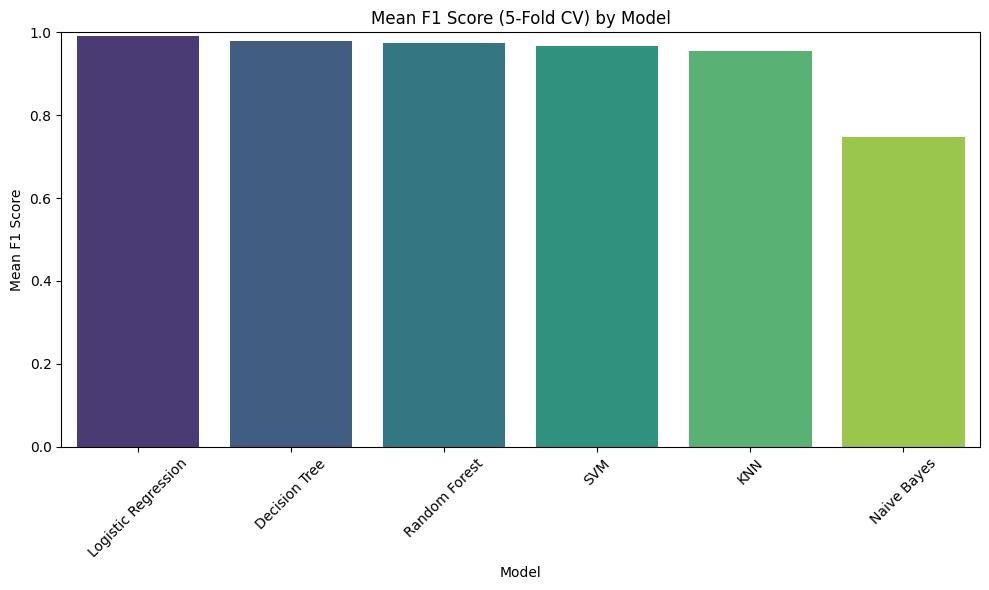

In [ ]:
cv_df = pd.DataFrame(cv_results).T.reset_index().rename(columns={'index': 'Model'})
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Mean F1 Score', data=cv_df, palette='viridis')
plt.title('Mean F1 Score (5-Fold CV) by Model')
plt.ylabel('Mean F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Confusion Matrix + F1 Score (Best Model)

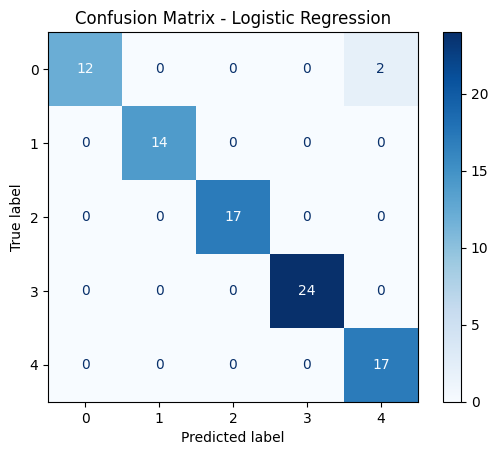

F1 Score (Weighted): 0.9765


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = models["Logistic Regression"]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

f1 = f1_score(y_test, y_pred_best, average='weighted')
print(f"F1 Score (Weighted): {f1:.4f}")


# Save Best Model and Preprocessors

In [ ]:
import joblib

# Save the best model
joblib.dump(models['Logistic Regression'], 'final_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(kmeans, 'kmeans.pkl')  # Optional if you want clustering again
joblib.dump(df, 'full_df_with_descriptions.pkl')  # For Flask use

from google.colab import files
files.download('final_model.pkl')
files.download('scaler.pkl')
files.download('label_encoders.pkl')
files.download('full_df_with_descriptions.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>